In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from dgl.data import DGLDataset
import dgl
import dgl.function as fn
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, ELU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6
import scipy.io
from dgl.nn import HeteroGraphConv
from dgl.utils import expand_as_pair

Using backend: pytorch


## Load and Normalize Data

In [2]:
train_layouts = 10000
test_layouts = 200

In [3]:
data = scipy.io.loadmat('cf_train_6_30.mat')
beta_train = data['betas'][:train_layouts]
direct_train = data['directs'][:train_layouts]
cross_train = data['corsses'][:train_layouts].transpose(0,2,1)

In [4]:
test_data = scipy.io.loadmat('cf_test_6_30.mat')
beta_test = test_data['betas']
direct_test = test_data['directs']
cross_test = test_data['corsses'].transpose(0,2,1)

In [5]:
def normalize_data(train_data,test_data):
    train_mean = np.mean(train_data)
    train_std = np.std(train_data)
    norm_train = (train_data)/train_std
    norm_test = (test_data)/train_std
    n1, n2 = norm_train.shape[0], norm_test.shape[0]
    return norm_train, norm_test
norm_train_losses, norm_test_losses = normalize_data(beta_train**(1/2), beta_test**(1/2) )

In [6]:
## For GNNs, we allow train_K \neq test_K
train_K, train_M = beta_train.shape[2], beta_train.shape[1]
test_K, test_M = beta_test.shape[2], beta_test.shape[1]

## Create Dataset
Please refer to https://docs.dgl.ai/en/0.6.x/guide/graph-heterogeneous.html#guide-graph-heterogeneous for a tutorial for the usage of DGL hetergenous graph dataset

In [7]:
class PCDataset(DGLDataset):
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = norm_losses
        self.direct = torch.tensor(direct, dtype = torch.float)
        self.cross = torch.tensor(cross, dtype = torch.float)
        self.KM = KM
        self.get_cg()
        super().__init__(name='power_control')
        
        
    def build_graph(self, idx):
        edge_feature = self.norm_losses[idx,:,:].reshape((self.KM[0]*self.KM[1],1), order = 'F')
        edge_feature = np.concatenate((edge_feature, np.ones_like(edge_feature)), axis = -1)
        graph = dgl.heterograph({('UE', 'com-by', 'AP'): self.adj, ('AP', 'com', 'UE') : self.adj_t})
        graph.nodes['UE'].data['feat'] = torch.ones((self.KM[0],1))
        graph.nodes['AP'].data['feat'] = torch.ones((self.KM[1],1))
        ## Initialize node feature as all one vector
        graph.edges['com-by'].data['feat'] = torch.tensor(edge_feature, dtype = torch.float)
        graph.edges['com'].data['feat'] = torch.tensor(edge_feature, dtype = torch.float)
        ## Edge feature: large-scale coefficients
        return graph
    
    def get_cg(self):
        ## The graph is a fully connected bipartite graph
        self.adj = []; self.adj_t = []
        for i in range(0,self.KM[0]):
            for j in range(0,self.KM[1]):
                self.adj.append([i,j])
                self.adj_t.append([j,i])
            
                    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.direct)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.graph_list[index], self.direct[index], self.cross[index]

    def process(self):
        n = len(self.direct)
        self.graph_list = []
        for i in range(n):
            graph = self.build_graph(i)
            self.graph_list.append(graph)

In [8]:
# Please refer to https://docs.dgl.ai/en/0.2.x/tutorials/basics/4_batch.html for details of collate
def collate(samples):
    '''DGL collate function'''
    graphs, direct, cross = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.stack(direct), torch.stack(cross)

In [9]:
train_data = PCDataset(norm_train_losses, direct_train, cross_train, (train_K, train_M))
test_data = PCDataset(norm_test_losses, direct_test, cross_test, (test_K, test_M))

In [10]:
## For heterogenous graph, nodes and edges have names
print(train_data[0][0].ntypes)

['AP', 'UE']


In [11]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, test_layouts, shuffle=False, collate_fn=collate)

## Build Graph Neural Networks

#### Define loss function
The loss function is similar to D2D case, differs in two aspects:
1. crosslink_channel_losses have diagonal part
2. Take minimum instead of sum

In [12]:
def rate_loss(allocs, directlink_channel_losses, crosslink_channel_losses, test_mode = False):
    SINRs_numerators = allocs * directlink_channel_losses**2
    SINRs_denominators = torch.squeeze(torch.matmul(crosslink_channel_losses, torch.unsqueeze(allocs, axis=-1))) + directlink_channel_losses
    SINRs = SINRs_numerators / SINRs_denominators
    rates = torch.log2(1 + SINRs)
    min_rate = torch.min(rates, dim = 1)[0] # take min
    if test_mode:
        return min_rate
    else:
        return -torch.mean(min_rate)

#### Message Passing Modules 
Please refer to https://docs.dgl.ai/en/0.6.x/guide/message-heterograph.html for the usage of DGL heterogenous message-passing

Chinese version: https://zhuanlan.zhihu.com/p/354258797

In [14]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class EdgeConv(nn.Module):
    def __init__(self, input_dim, node_dim, **kwargs):
        super(EdgeConv, self).__init__()
        self.lin = MLP([input_dim, 32])
        self.res_lin = Lin(node_dim, 32)
        self.bn = BN(32)
        #self.reset_parameters()

    def concat_message_function(self, edges):
        return {'out': torch.cat([edges.src['hid'], edges.dst['hid'], edges.data['feat']], axis=1)}
    
    def forward(self, g, inputs):
        with g.local_scope():
            feat_src, feat_dst = expand_as_pair(inputs, g)
            g.srcdata['hid'] = feat_src
            g.dstdata['hid'] = feat_dst
            
            g.apply_edges(self.concat_message_function)
            g.edata['out'] = self.lin(g.edata['out'])
            g.update_all(fn.copy_edge('out', 'm'),
                         fn.mean('m', 'hid'))
            return g.dstdata['hid'] + self.res_lin(feat_dst)

#### GNN Modules 
Please refer to https://docs.dgl.ai/en/0.6.x/guide/nn-heterograph.html and for usage of DGL Heterogenous GNN

Chinese version: https://zhuanlan.zhihu.com/p/354258797

In [15]:
class RGCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = HeteroGraphConv({rel:EdgeConv(4,1)
                                            for rel in ['com', 'com-by']}, aggregate='mean')
        self.conv2= HeteroGraphConv({rel:EdgeConv(66,32)
                                            for rel in ['com', 'com-by']}, aggregate='mean')
        self.conv3 = HeteroGraphConv({rel:EdgeConv(66,32)
                                            for rel in ['com', 'com-by']}, aggregate='mean')
        self.mlp = MLP([32, 16])
        self.mlp = Seq(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, g, inputs):
        out = self.conv1(g, inputs)
        out = self.conv2(g, out)
        out = self.conv3(g, out)
        out = self.mlp(out['UE'])
        return out

In [16]:
model = RGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

## Training and Test
The training is similar to the node regression on homogenous graph, please refer to https://docs.dgl.ai/en/0.6.x/guide/training-node.html for DGL node regression training

In [17]:
def train(epoch):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (g, d_train, c_train) in enumerate(train_loader):
        #data = data.to(device)
        K = d_train.shape[-1]
        n = len(g.nodes['UE'].data['feat'])
        bs = len(g.nodes['UE'].data['feat'])//K
        
        optimizer.zero_grad()
        
        user_feats = g.nodes['AP'].data['feat']
        item_feats = g.nodes['UE'].data['feat']
        node_features = {'AP': user_feats, 'UE': item_feats}
        output = model(g, node_features).reshape(bs,-1)
        
        loss = rate_loss(output, d_train, c_train)
        loss.backward()
        
        loss_all += loss.item() * bs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

In [18]:
def test(loader):
    model.eval()
    correct = 0
    for (g, d_test, c_test) in loader:
        K = d_test.shape[-1]
        n = len(g.nodes['UE'].data['feat'])
        bs = len(g.nodes['UE'].data['feat'])//K
        
        user_feats = g.nodes['AP'].data['feat']
        item_feats = g.nodes['UE'].data['feat']
        node_features = {'AP': user_feats, 'UE': item_feats}
        output = model(g, node_features).reshape(bs,-1)
        
        loss = rate_loss(output, d_test, c_test)
        correct += loss.item() * bs
    return correct / len(loader.dataset)

In [19]:
record = []
for epoch in range(0, 30):
    if(epoch % 1 == 0):
        with torch.no_grad():
            train_rate = test(train_loader)
            test_rate = test(test_loader)
        print('Epoch {:03d}, Train Rate: {:.4f}, Test Rate: {:.4f}'.format(
            epoch, train_rate, test_rate))
        record.append([train_rate, test_rate])
    train(epoch)
    scheduler.step()

Epoch 000, Train Rate: -0.5359, Test Rate: -0.5163
Epoch 001, Train Rate: -0.8138, Test Rate: -0.7918
Epoch 002, Train Rate: -0.8822, Test Rate: -0.8598
Epoch 003, Train Rate: -0.9169, Test Rate: -0.8946
Epoch 004, Train Rate: -0.9300, Test Rate: -0.9073
Epoch 005, Train Rate: -0.9500, Test Rate: -0.9274
Epoch 006, Train Rate: -0.9689, Test Rate: -0.9470
Epoch 007, Train Rate: -0.9737, Test Rate: -0.9511
Epoch 008, Train Rate: -0.9890, Test Rate: -0.9670
Epoch 009, Train Rate: -1.0002, Test Rate: -0.9829
Epoch 010, Train Rate: -1.0105, Test Rate: -1.0011
Epoch 011, Train Rate: -1.0266, Test Rate: -1.0180
Epoch 012, Train Rate: -1.0254, Test Rate: -1.0199
Epoch 013, Train Rate: -1.0404, Test Rate: -1.0366
Epoch 014, Train Rate: -1.0423, Test Rate: -1.0372
Epoch 015, Train Rate: -1.0465, Test Rate: -1.0457
Epoch 016, Train Rate: -1.0465, Test Rate: -1.0470
Epoch 017, Train Rate: -1.0532, Test Rate: -1.0559
Epoch 018, Train Rate: -1.0515, Test Rate: -1.0540
Epoch 019, Train Rate: -1.0488,

## Plot CDF

In [24]:
## For CDF Plot
import matplotlib.pyplot as plt
for (g, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(g.nodes['UE'].data['feat'])
    bs = len(g.nodes['UE'].data['feat'])//K
    #data = data.to(device)
    user_feats = g.nodes['AP'].data['feat']
    item_feats = g.nodes['UE'].data['feat']
    node_features = {'AP': user_feats, 'UE': item_feats}
    output = model(g, node_features).reshape(bs,-1)
    gnn_rates = rate_loss(output, d_test, c_test, True).flatten().detach().numpy()
    
    full = torch.ones_like(output)
    all_one_rates = rate_loss(full, d_test, c_test, True).flatten().numpy()
    
## Load optimal resource allocation from .mat file
test_data = scipy.io.loadmat('cf_test_6_30.mat')
opt_rates = test_data['R_cf_opt_min']

In [25]:
min_rate, max_rate = 0, 2
y_axis = np.arange(0, 1.0, 1/202)
gnn_rates.sort(); all_one_rates.sort(); opt_rates.sort()
gnn_rates = np.insert(gnn_rates, 0, min_rate); gnn_rates = np.insert(gnn_rates,201,max_rate)
all_one_rates = np.insert(all_one_rates, 0, min_rate); all_one_rates = np.insert(all_one_rates,201,max_rate)
opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,201,max_rate)

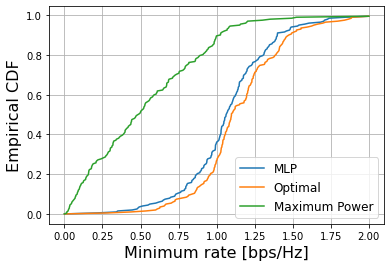

In [27]:
plt.plot(gnn_rates, y_axis, label = 'GNN')
plt.plot(opt_rates, y_axis, label = 'Optimal')
plt.plot(all_one_rates, y_axis, label = 'Maximum Power')
plt.xlabel('Minimum rate [bps/Hz]', {'fontsize':16})
plt.ylabel('Empirical CDF', {'fontsize':16})
plt.legend(fontsize = 12)
plt.grid()